Spot data columns: ['Date', 'Price']
Futures data columns: ['Date', 'Price']

Spot data shape: (1442, 2)
Futures data shape: (1070, 2)
MERGED DATA
Shape before cleaning: (1444, 2)

First few rows:
             Spot  Futures
Date                      
2020-01-02  61.17    61.18
2020-01-03  63.00    63.05
2020-01-06  63.27    63.27
2020-01-07  62.70    62.70
2020-01-08  59.65    59.61

Checking for extreme outliers (negative prices)...
Found 1 observations with negative prices:
             Spot  Futures
Date                      
2020-04-20 -36.98   -37.63

Removing negative price observations (April 2020 anomaly)...
Remaining observations after removing negative prices: 1067

Filtering data to January 2020 - March 2024...
Observations in selected date range: 1062
DATA SUMMARY
Date range: 2020-01-02 00:00:00 to 2024-03-28 00:00:00
Number of observations: 1062

Descriptive Statistics:
              Spot      Futures
count  1062.000000  1062.000000
mean     70.428117    70.287269
std     

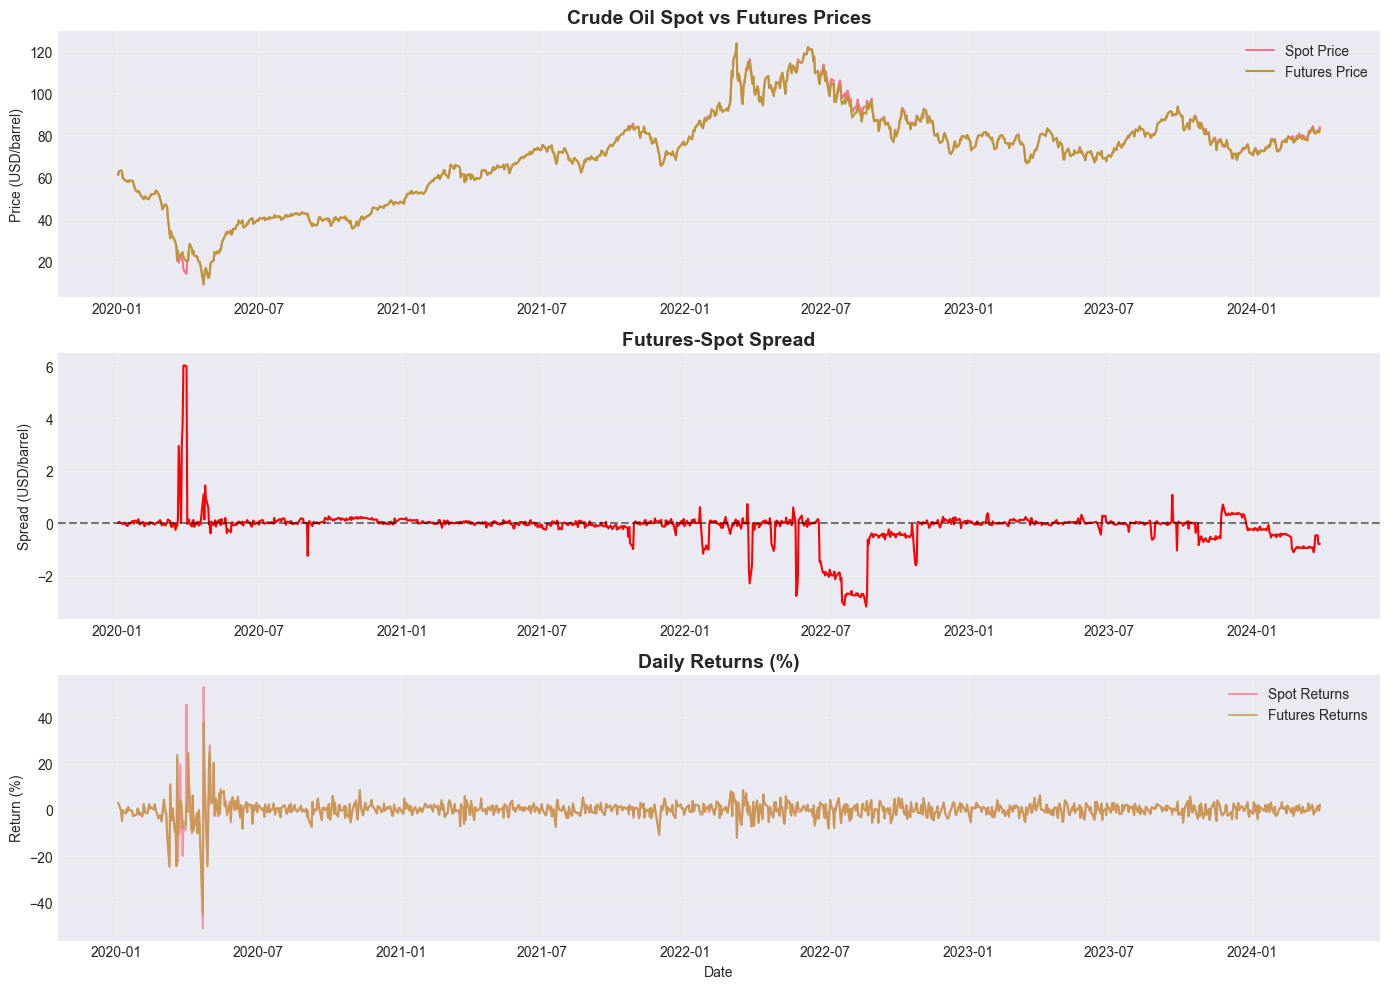


Correlation between Spot and Futures: 0.9996


In [ ]:
# Crude Oil Futures and Spot Price Cointegration Analysis
# Install required packages first (run once):
# pip install pandas numpy matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [ ]:
# ============================================================================
# COMPREHENSIVE UNIT ROOT TESTS - ALL THREE METHODS
# ============================================================================

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd
import numpy as np

def perform_all_unit_root_tests(df):
    """
    Perform ADF, PP, and KPSS tests on levels and first differences
    Returns a formatted summary table
    """

    results = []

    for col in ['Spot', 'Futures']:
        # ===== LEVEL TESTS =====
        series_level = df[col].dropna()

        # 1. ADF Test - Level
        adf_level = adfuller(series_level, autolag='AIC')

        # 2. PP Test - Level
        pp_level = PhillipsPerron(series_level, trend='c')

        # 3. KPSS Test - Level
        nlags_level = int(12 * (len(series_level) / 100) ** (1/4))
        kpss_level = kpss(series_level, regression='c', nlags=nlags_level)

        # ===== FIRST DIFFERENCE TESTS =====
        series_diff = df[col].diff().dropna()

        # 1. ADF Test - First Difference
        adf_diff = adfuller(series_diff, autolag='AIC')

        # 2. PP Test - First Difference
        pp_diff = PhillipsPerron(series_diff, trend='c')

        # 3. KPSS Test - First Difference
        nlags_diff = int(12 * (len(series_diff) / 100) ** (1/4))
        kpss_diff = kpss(series_diff, regression='c', nlags=nlags_diff)

        # Store results
        results.append({
            'Variable': f'{col} Price',
            'ADF_Level': adf_level[0],
            'ADF_Level_pval': adf_level[1],
            'ADF_Diff': adf_diff[0],
            'ADF_Diff_pval': adf_diff[1],
            'PP_Level': pp_level.stat,
            'PP_Level_pval': pp_level.pvalue,
            'PP_Diff': pp_diff.stat,
            'PP_Diff_pval': pp_diff.pvalue,
            'KPSS_Level': kpss_level[0],
            'KPSS_Level_pval': kpss_level[1],
            'KPSS_Diff': kpss_diff[0],
            'KPSS_Diff_pval': kpss_diff[1]
        })

    return pd.DataFrame(results)

def add_significance_stars(stat, pval, test_type='ADF'):
    """
    Add significance stars based on p-value
    For KPSS, interpretation is reversed
    """
    if test_type == 'KPSS':
        # KPSS: reject H0 means non-stationary (we want high p-value for stationarity)
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.10:
            stars = '*'
        return f"{stat:.4f}{stars}"
    else:
        # ADF/PP: reject H0 means stationary (we want low p-value for stationarity)
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.10:
            stars = '*'
        return f"{stat:.4f}{stars}"

# Run all tests
results_df = perform_all_unit_root_tests(df)

# ============================================================================
# FORMAT 1: DETAILED TABLE (For Technical Appendix)
# ============================================================================
print("\n" + "="*100)
print("TABLE: UNIT ROOT TEST RESULTS - DETAILED")
print("="*100)
print("\n{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "Variable", "ADF (Level)", "ADF (Diff)", "PP (Level)", "PP (Diff)", "KPSS (Level)", "KPSS (Diff)"
))
print("-" * 100)

for idx, row in results_df.iterrows():
    print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
        row['Variable'],
        add_significance_stars(row['ADF_Level'], row['ADF_Level_pval'], 'ADF'),
        add_significance_stars(row['ADF_Diff'], row['ADF_Diff_pval'], 'ADF'),
        add_significance_stars(row['PP_Level'], row['PP_Level_pval'], 'PP'),
        add_significance_stars(row['PP_Diff'], row['PP_Diff_pval'], 'PP'),
        add_significance_stars(row['KPSS_Level'], row['KPSS_Level_pval'], 'KPSS'),
        add_significance_stars(row['KPSS_Diff'], row['KPSS_Diff_pval'], 'KPSS')
    ))

print("\nNotes: ***, **, * denote significance at 1%, 5%, and 10% levels, respectively.")
print("For ADF and PP tests: Rejection of H₀ indicates stationarity.")
print("For KPSS test: Rejection of H₀ indicates non-stationarity.")
print("All series are I(1) - non-stationary in levels, stationary in first differences.")



TABLE: UNIT ROOT TEST RESULTS - DETAILED

Variable        ADF (Level)     ADF (Diff)      PP (Level)      PP (Diff)       KPSS (Level)    KPSS (Diff)    
----------------------------------------------------------------------------------------------------
Spot Price      -1.2625         -15.0794***     -1.4106         -32.2368***     2.7551**        0.0882         
Futures Price   -1.2545         -15.2515***     -1.4165         -31.6918***     2.7614**        0.0883         

Notes: ***, **, * denote significance at 1%, 5%, and 10% levels, respectively.
For ADF and PP tests: Rejection of H₀ indicates stationarity.
For KPSS test: Rejection of H₀ indicates non-stationarity.
All series are I(1) - non-stationary in levels, stationary in first differences.

TABLE: UNIT ROOT TEST RESULTS - PRESENTATION FORMAT

┌─────────────────┬──────────────────────────────────┬──────────────────────────────────┐
│                 │            Level                 │       First Difference           │
│   

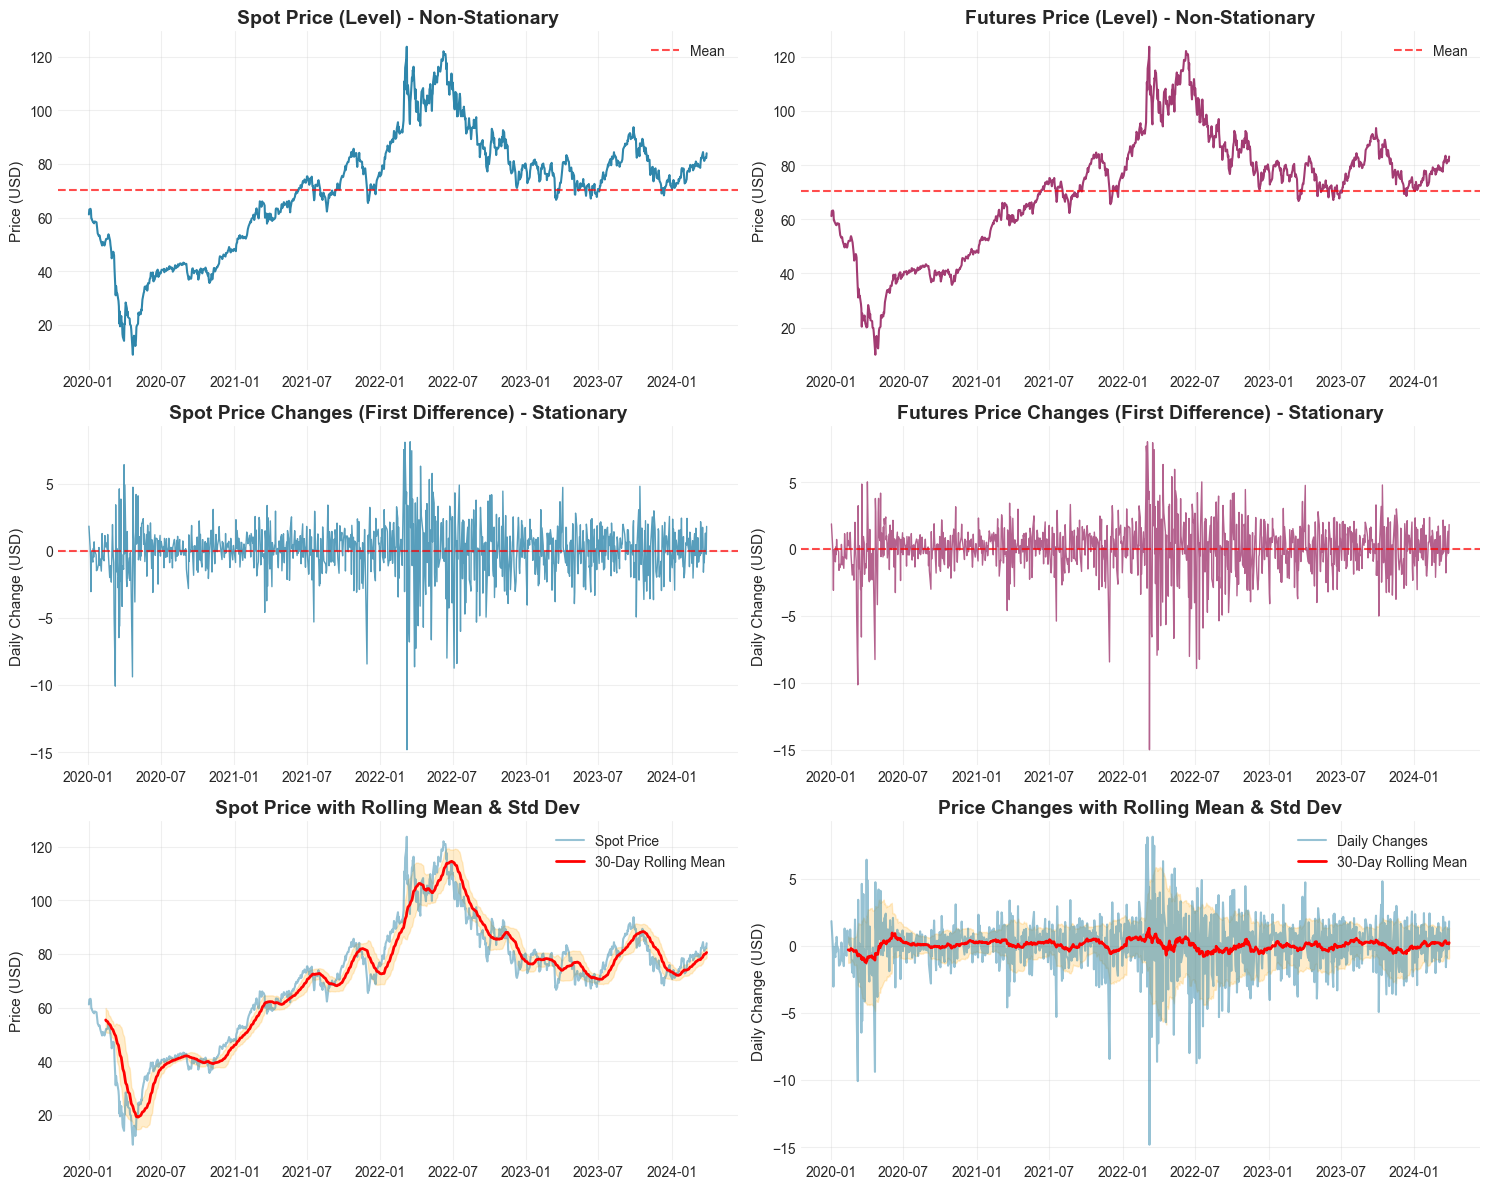

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot 1: Spot Price (Level)
axes[0, 0].plot(df.index, df['Spot'], color='#2E86AB', linewidth=1.5)
axes[0, 0].set_title('Spot Price (Level) - Non-Stationary', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price (USD)', fontsize=11)
axes[0, 0].axhline(y=df['Spot'].mean(), color='red', linestyle='--', alpha=0.7, label='Mean')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Futures Price (Level)
axes[0, 1].plot(df.index, df['Futures'], color='#A23B72', linewidth=1.5)
axes[0, 1].set_title('Futures Price (Level) - Non-Stationary', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price (USD)', fontsize=11)
axes[0, 1].axhline(y=df['Futures'].mean(), color='red', linestyle='--', alpha=0.7, label='Mean')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Spot Price First Difference
spot_diff = df['Spot'].diff().dropna()
axes[1, 0].plot(df.index[1:], spot_diff, color='#2E86AB', linewidth=1, alpha=0.8)
axes[1, 0].set_title('Spot Price Changes (First Difference) - Stationary', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Daily Change (USD)', fontsize=11)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Futures Price First Difference
futures_diff = df['Futures'].diff().dropna()
axes[1, 1].plot(df.index[1:], futures_diff, color='#A23B72', linewidth=1, alpha=0.8)
axes[1, 1].set_title('Futures Price Changes (First Difference) - Stationary', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Daily Change (USD)', fontsize=11)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Rolling Mean (Shows non-stationarity)
rolling_mean_spot = df['Spot'].rolling(window=30).mean()
rolling_std_spot = df['Spot'].rolling(window=30).std()
axes[2, 0].plot(df.index, df['Spot'], color='#2E86AB', alpha=0.5, label='Spot Price')
axes[2, 0].plot(df.index, rolling_mean_spot, color='red', linewidth=2, label='30-Day Rolling Mean')
axes[2, 0].fill_between(df.index, rolling_mean_spot - rolling_std_spot,
                        rolling_mean_spot + rolling_std_spot, alpha=0.2, color='orange')
axes[2, 0].set_title('Spot Price with Rolling Mean & Std Dev', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Price (USD)', fontsize=11)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Rolling Mean for First Difference
rolling_mean_diff = spot_diff.rolling(window=30).mean()
rolling_std_diff = spot_diff.rolling(window=30).std()
axes[2, 1].plot(df.index[1:], spot_diff, color='#2E86AB', alpha=0.5, label='Daily Changes')
axes[2, 1].plot(df.index[1:], rolling_mean_diff, color='red', linewidth=2, label='30-Day Rolling Mean')
axes[2, 1].fill_between(df.index[1:], rolling_mean_diff - rolling_std_diff,
                        rolling_mean_diff + rolling_std_diff, alpha=0.2, color='orange')
axes[2, 1].set_title('Price Changes with Rolling Mean & Std Dev', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Daily Change (USD)', fontsize=11)
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('unit_root_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

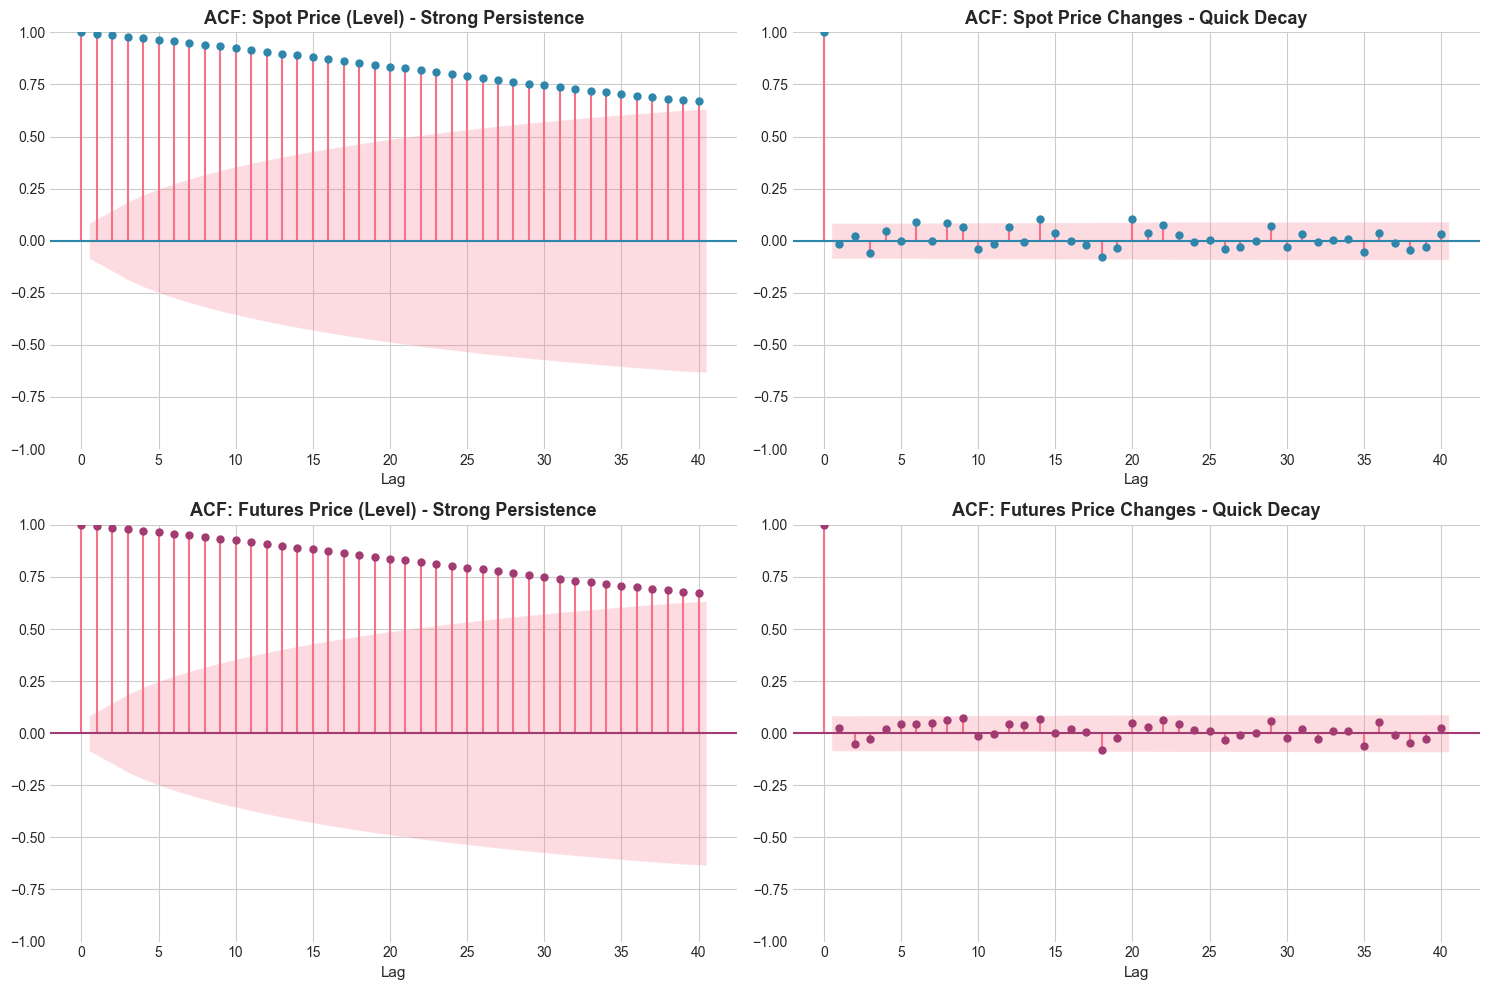

INTERPRETATION:
Non-stationary (Level): ACF decays VERY slowly → Long memory
Stationary (Difference): ACF drops quickly → Short memory


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF for Spot Price Level
plot_acf(df['Spot'].dropna(), lags=40, ax=axes[0, 0], color='#2E86AB')
axes[0, 0].set_title('ACF: Spot Price (Level) - Strong Persistence', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Lag', fontsize=11)

# ACF for Spot Price First Difference
plot_acf(df['Spot'].diff().dropna(), lags=40, ax=axes[0, 1], color='#2E86AB')
axes[0, 1].set_title('ACF: Spot Price Changes - Quick Decay', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Lag', fontsize=11)

# ACF for Futures Price Level
plot_acf(df['Futures'].dropna(), lags=40, ax=axes[1, 0], color='#A23B72')
axes[1, 0].set_title('ACF: Futures Price (Level) - Strong Persistence', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Lag', fontsize=11)

# ACF for Futures Price First Difference
plot_acf(df['Futures'].diff().dropna(), lags=40, ax=axes[1, 1], color='#A23B72')
axes[1, 1].set_title('ACF: Futures Price Changes - Quick Decay', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=11)

plt.tight_layout()
plt.savefig('acf_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("Non-stationary (Level): ACF decays VERY slowly → Long memory")
print("Stationary (Difference): ACF drops quickly → Short memory")

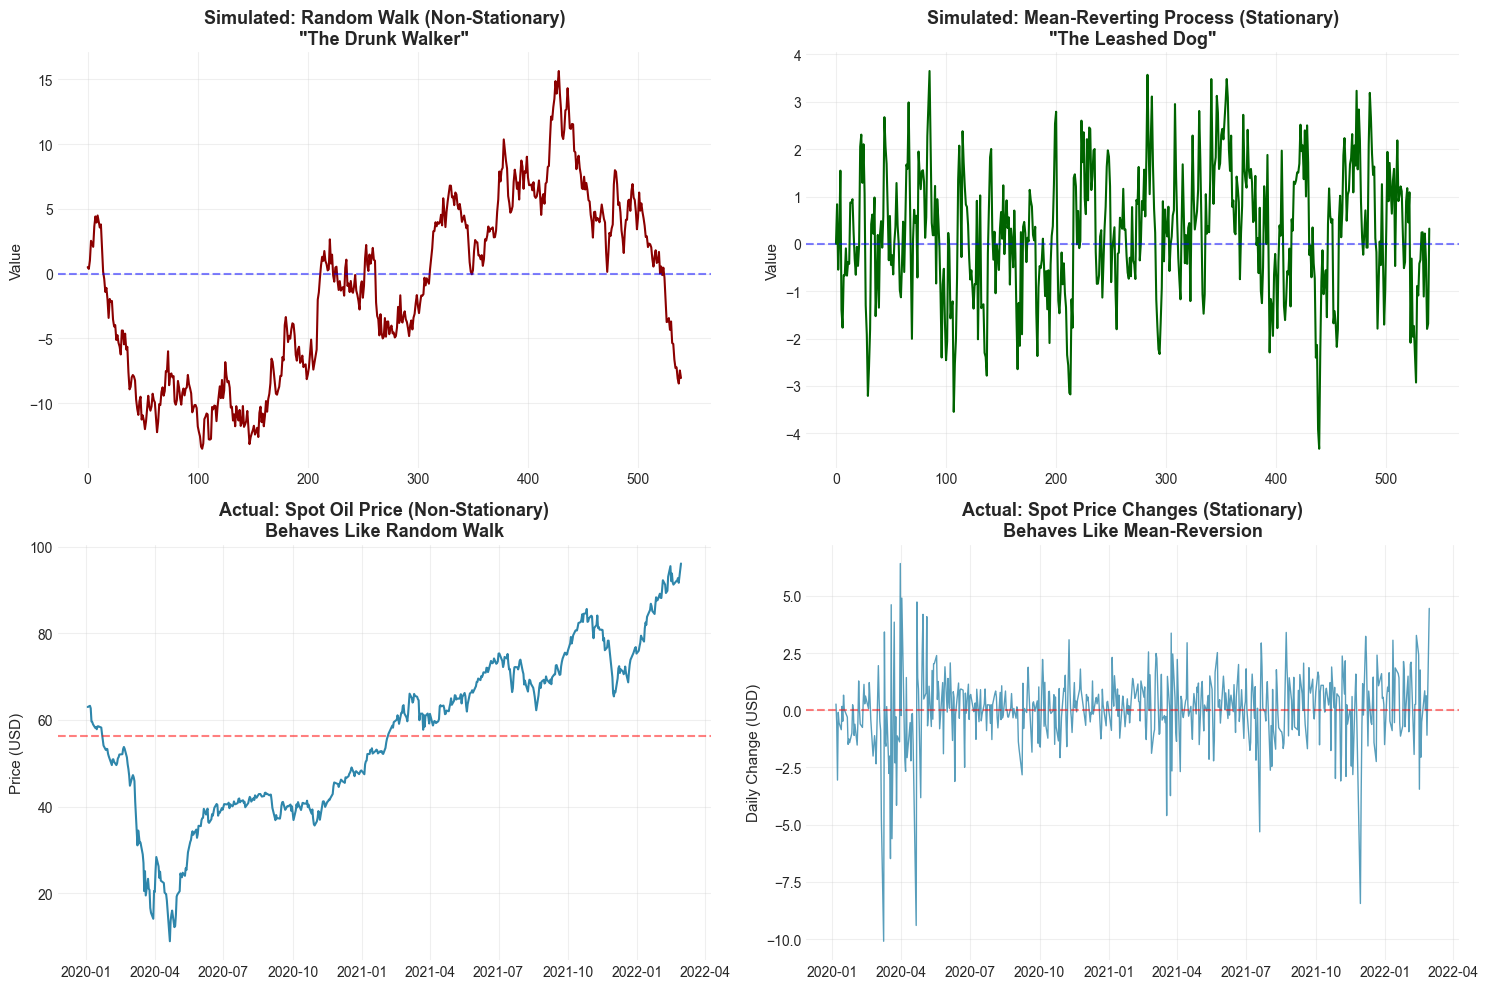

In [ ]:
# Simulate processes to show the difference
np.random.seed(42)
n = len(df)

# Simulate Random Walk (Non-Stationary)
random_walk = np.cumsum(np.random.randn(n))

# Simulate Mean-Reverting Process (Stationary)
stationary = np.zeros(n)
for i in range(1, n):
    stationary[i] = 0.7 * stationary[i-1] + np.random.randn()

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Simulated Random Walk
axes[0, 0].plot(random_walk, color='darkred', linewidth=1.5)
axes[0, 0].set_title('Simulated: Random Walk (Non-Stationary)\n"The Drunk Walker"',
                     fontsize=13, fontweight='bold')
axes[0, 0].axhline(y=0, color='blue', linestyle='--', alpha=0.5)
axes[0, 0].set_ylabel('Value', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Simulated Stationary Process
axes[0, 1].plot(stationary, color='darkgreen', linewidth=1.5)
axes[0, 1].set_title('Simulated: Mean-Reverting Process (Stationary)\n"The Leashed Dog"',
                     fontsize=13, fontweight='bold')
axes[0, 1].axhline(y=0, color='blue', linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('Value', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Actual Spot Price (looks like random walk)
axes[1, 0].plot(df.index, df['Spot'], color='#2E86AB', linewidth=1.5)
axes[1, 0].set_title('Actual: Spot Oil Price (Non-Stationary)\nBehaves Like Random Walk',
                     fontsize=13, fontweight='bold')
axes[1, 0].axhline(y=df['Spot'].mean(), color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_ylabel('Price (USD)', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Actual Price Changes (looks mean-reverting)
axes[1, 1].plot(df.index[1:], spot_diff, color='#2E86AB', linewidth=1, alpha=0.8)
axes[1, 1].set_title('Actual: Spot Price Changes (Stationary)\nBehaves Like Mean-Reversion',
                     fontsize=13, fontweight='bold')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_ylabel('Daily Change (USD)', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simulation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()